## Introduction

The only function [exported](https://docs.julialang.org/en/v1/manual/modules/#Export-lists) by [Findr.jl][1] is the [`findr`](https://tmichoel.github.io/Findr.jl/dev/testLLR/) function itself. Nevertheless, many of the internal functions may be useful when digging deeper in the results for specific genes. The [package documentation][6] contains detailed descriptions of all package functions, intertwined with the methods section of the [original paper][5], and should give a good overview of what is available. To illustrate how these functions can be used, we will reproduce the following figure ([Supplementary Fig. S1](https://doi.org/10.1371/journal.pcbi.1005703.s002) from the  [original paper][5]):

![LLR distribution of the relevance test for hsa-miR-200b-3p on 23722 potential targets of Geuvadis dataset.](figures/eg4.png)


## Set up the environment


In [1]:
using DrWatson
quickactivate(@__DIR__)

using DataFrames
using Arrow
using StatsPlots
using LaTeXStrings
using Distributions

using Findr

## Load data

You should by now be familiar with the GEUVADIS data used in the *First steps* tutorials. Here we need the following files:


In [2]:
dt = DataFrame(Arrow.Table(datadir("exp_pro","findr-data-geuvadis", "dt.arrow")));
dm = DataFrame(Arrow.Table(datadir("exp_pro","findr-data-geuvadis", "dm.arrow")));
dgm = DataFrame(Arrow.Table(datadir("exp_pro","findr-data-geuvadis", "dgm.arrow")));

We also need the microRNA eQTL mapping (see the [causal inference tutorial](causal-inference.qmd)):


In [3]:
dpm = DataFrame(SNP_ID = names(dgm), GENE_ID=names(dm)[1:ncol(dgm)]);

Set the microRNA of interest:


In [4]:
mirA = "hsa-miR-200b-3p";

## Run the analysis

### Convert the data

Internally, all [Findr.jl][1] functions use matrix-based inputs and [supernormalized data](https://tmichoel.github.io/Findr.jl/dev/inference/). The easiest way to convert our data is to run `supernormalize` on the initial data:


In [5]:
Yt = Findr.supernormalize(dt);
Ym = vec(Findr.supernormalize(select(dm,mirA)));

For the genotype data, no conversion is needed:


In [6]:
E = dgm[:, dpm.SNP_ID[dpm.GENE_ID.==mirA][1]];

We will also need the number of samples and number of genotype groups:


In [7]:
ns = length(E);
ng = length(unique(E));

### Compute log-likelihood ratios

Throughout the package, the [likelihood ratio tests](https://tmichoel.github.io/Findr.jl/dev/realLLR/) are labelled by the following [symbols](https://docs.julialang.org/en/v1/manual/metaprogramming/#Symbols)

- Test 2 (**Linkage test**): `:link`
- Test 3 (**Mediation test**): `:med`
- Test 4 (**Relevance test**): `:relev`
- Test 5 (**Pleiotropy test**): `:pleio`

Since [all log-likelihood ratios are computed from the same summary statistics](https://tmichoel.github.io/Findr.jl/dev/realLLR/#Implementation), a single function computes them all. To compute the log-likelihood ratios for a specific A-gene (here: hsa-miR-200b-3p with column vector of expression data `Ym`) with a causal instrument (best eQTL) with genotype vector `E`, run:


In [8]:
llr2, llr3, llr4, llr5 = Findr.realLLR_col(Yt, Ym, E);

If you know you're only going to use one of them, you can also run:


In [9]:
_ , _ , llr4 , _ = Findr.realLLR_col(Yt, Ym, E);

### Compute posterior probabilities

Posterior probabilities are computed by [fitting a mixture model](https://tmichoel.github.io/Findr.jl/dev/posteriorprobs/) to the observed vector of log-likelihood ratios. Two fitting methods are implmented: a [method of moments](https://tmichoel.github.io/Findr.jl/dev/posteriorprobs/#mom_postprobs) or using [kernel density estimation](https://tmichoel.github.io/Findr.jl/dev/posteriorprobs/#kde_postprobs). The method of moments is the default:


In [10]:
pp_mom, dmix = Findr.fit_mixdist_mom(llr4, ns, ng, :relev);

The KDE estimate is obtained similarly:


In [11]:
pp_kde = Findr.fit_mixdist_KDE(llr4, ns, ng, :relev);

The method of moments has a second output argument, `dmix`, a [mixture model distribution object](https://juliastats.org/Distributions.jl/stable/mixture/) where each mixture component is an [`LBeta` dsitribution](https://tmichoel.github.io/Findr.jl/dev/randomLLR/#Implementation):


In [12]:
dmix

MixtureModel{Findr.LBeta}(K = 2)
components[1] (prior = 0.7563): Findr.LBeta(α=3.0, β=356.0)
components[2] (prior = 0.2437): Findr.LBeta(α=4.8444856311440025, β=283.963310322944)


The first component in the mixture model is the null distribution, which can also be created as follows:


In [13]:
dnull = Findr.nulldist(ns,ng,:relev)

Findr.LBeta(α=3.0, β=356.0)

The `prior` of the null component is the [estimated proportion of truly null features](https://tmichoel.github.io/Findr.jl/dev/posteriorprobs/#Estimating-P({\\mathcal-H}_{\\mathrm{null}})) in the observed log-likelihood ratio vector `llr4`:


In [14]:
π₀ = dmix.prior.p[1]

0.7562600118033892

We can verify that both methods (moments and KDE) give similar posterior probabilities

```julia
scatter(pp_mom,pp_kde, markersize=4)
```

### Compute p-values under the null hypothesis

We don't need null p-values to reproduce the figure above, but they can be used to assess the quality of the $\pi_0$ estimate.


In [15]:
pnull = Findr.nullpval(llr4,ns,ng,:relev);

We can verify that the histogram shows the [characteristic shape of a set of anti-conservative p-values](http://varianceexplained.org/statistics/interpreting-pvalue-histogram/) and that $\pi_0$ correctly estimates the height of the "flat" portion of the histogram near $p\approx 1$:


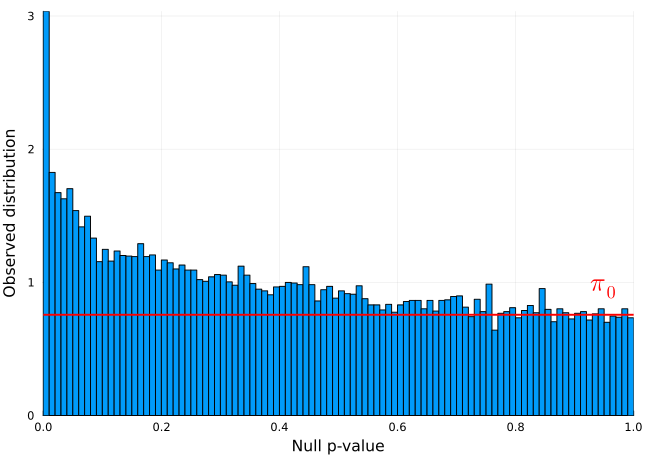

In [16]:
histogram(pnull, normalize=:pdf, bins=100, label="")
hline!([π₀],linewidth=2, label="", linecolor=:red)
xlims!(0,1)
xlabel!("Null p-value")
ylabel!("Observed distribution")
annotate!(0.95,0.95, (L"\pi_0", 18, :red))

## Reproduce the figure

### Method of moments estimates

For the method of moments, the null and real log-likelihood ratio distribution are available in the form of [distribution objects](https://juliastats.org/Distributions.jl/), and we can simply evaluate their pdfs on a range of values:


In [17]:
lval = range(0,maximum(llr4),500);
pnull_val = π₀ * pdf.(dnull,lval);
preal_val = pdf.(dmix,lval);
pp_val = 1 .- pnull_val ./ preal_val;

Plot the final figure:


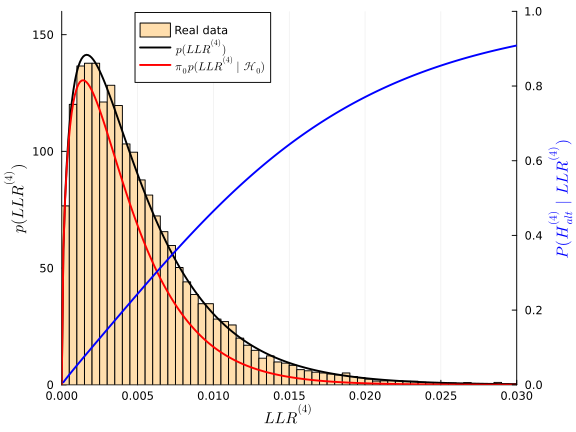

In [18]:
histogram(llr4, normalize=:pdf, bins=100, color=:navajowhite1, label="Real data", size=(600,450))
plot!(lval,preal_val, linewidth=2, color=:black, label=L"p(LLR^{(4)})")
plot!(lval,pnull_val, linewidth=2, color=:red, label=L"\pi_0 p(LLR^{(4)} \mid \mathcal{H}_0)", legend=(0.25,0.95))
ylims!(0, 160)
xlabel!(L"LLR^{(4)}")
ylabel!(L"p(LLR^{(4)})")
plot!(twinx(),lval,pp_val, linewidth=2, color=:blue, label="", yguidefontcolor=:blue, ylims=(0,1.), ylabel=L"P(H^{(4)}_{alt} \mid LLR^{(4)})")
#ylabel(L"P(H^{(4)}_{alt} \mid LLR^{(4)})")
xlims!(0,0.03)

Compared to the figure at the top of the page, we see that the method of moments provides a smooth fit to the histogram and consequently also posterior probabilities that increase more smoothly with increasing LLR values. 

### KDE estimates

For the KDE method, we don't have a distribution object fitting the histogram. Instead with use kernel density estimation and return estimated pdf values at every value of the LLR input vector:


In [19]:
preal_kde = Findr.fit_kde(llr4);

For plotting, we filter a relevant range of values from all vectors:


In [20]:
rg = 1:50:length(llr4);
t = sortperm(llr4);
lval_kde = llr4[t][rg];
preal_val_kde = preal_kde[t][rg];
pp_val_kde = pp_kde[t][rg];

And plot the figure again:


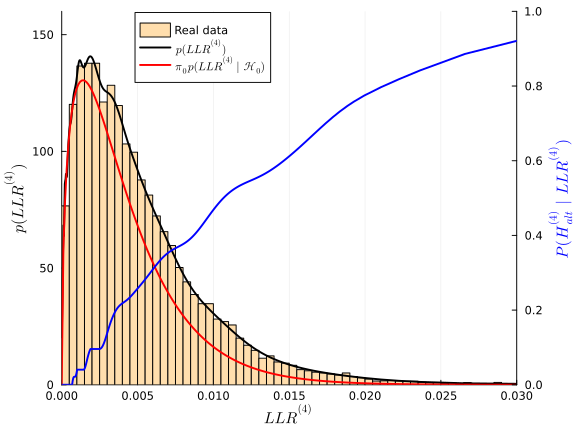

In [21]:
histogram(llr4, normalize=:pdf, bins=100, color=:navajowhite1, label="Real data", size=(600,450))
plot!(lval_kde,preal_val_kde, linewidth=2, color=:black, label=L"p(LLR^{(4)})")
plot!(lval,pnull_val, linewidth=2, color=:red, label=L"\pi_0 p(LLR^{(4)} \mid \mathcal{H}_0)", legend=(0.25,0.95))
ylims!(0, 160)
xlabel!(L"LLR^{(4)}")
ylabel!(L"p(LLR^{(4)})")
plot!(twinx(),lval_kde,pp_val_kde, linewidth=2, color=:blue, label="", yguidefontcolor=:blue, ylims=(0,1.), ylabel=L"P(H^{(4)}_{alt} \mid LLR^{(4)})")
#ylabel(L"P(H^{(4)}_{alt} \mid LLR^{(4)})")
xlims!(0,0.03)

[1]: https://github.com/tmichoel/Findr.jl
[2]: https://github.com/lingfeiwang/findr-data-geuvadis
[3]: https://doi.org/10.1038/nature12531
[4]: https://dataframes.juliadata.org/stable/
[5]: https://doi.org/10.1371/journal.pcbi.1005703
[6]: https://tmichoel.github.io/Findr.jl/dev/